### Методология анализа и выбора показателей

---

#### 1. RFM-анализ
Показатели:
- Recency (R): Время с момента последней покупки клиента.
  - *Цель*: Определение актуальности клиента. Чем меньше значение, тем выше вероятность повторной покупки.
- Frequency (F): Количество покупок за анализируемый период.
  - *Цель*: Оценка лояльности и вовлеченности клиента.
- Monetary (M): Сумма, потраченная клиентом за период.
  - *Цель*: Определение экономической ценности клиента.

Почему RFM?
- Сегментирует клиентов по поведению и ценности.
- Универсален для разных отраслей (розница, e-commerce, SaaS).
- Легко интерпретируется и преобразуется в бизнес-действия.

---

#### 2. Предобработка данных
Методы:
- Стандартизация данных (например, `StandardScaler`).
  - *Цель*: K-means чувствителен к масштабу данных. Стандартизация устраняет перекосы между признаками.
- Обработка выбросов.
  - *Цель*: Высокие значения Monetary или Frequency могут искажать кластеризацию.

---

#### 3. Кластеризация (K-means)
Метод:
- Алгоритм K-means для группировки клиентов по RFM-показателям.
  - *Цель*: Простота реализации, эффективность для больших данных, работа с числовыми признаками.

Критерии выбора числа кластеров (K):
- Метод локтя (Elbow Method): Анализ уменьшения Within-Cluster Sum of Squares (WCSS) при увеличении K.
  - *Цель*: Поиск точки, где добавление кластеров перестает давать значимое улучшение.
- Силуэтный коэффициент (Silhouette Score): Оценка компактности и разделимости кластеров (от -1 до 1).
  - *Цель*: Определение качества распределения клиентов по кластерам.

Пример:
- Оптимальное K=3 выбрано, так как:
  - Silhouette Score был максимальным для K=2, но требовалась более детальная сегментация.
  - Метод локтя показал "изгиб" на K=3, что стало компромиссом между точностью и интерпретируемостью.

---

#### 4. Визуализация
Методы:
- PCA (Principal Component Analysis): Линейное уменьшение размерности до 2D.
  - *Цель*: Упрощение визуализации с сохранением максимальной дисперсии данных.
- t-SNE (t-Distributed Stochastic Neighbor Embedding): Нелинейное уменьшение размерности.
  - *Цель*: Выявление скрытых паттернов и локальных структур.

Почему оба метода?
- PCA — для быстрой предварительной оценки.
- t-SNE — для детального анализа нелинейных зависимостей.

---

#### 5. Интерпретация кластеров
Методы:
- Анализ средних значений RFM в каждом кластере.
  - *Пример*:
    - Кластер 0: Высокие R, F, M → Лояльные VIP-клиенты.
    - Кластер 1: Низкое R, высокие F, M → Потерянные ценные клиенты.
- Бизнес-контекст: Соотнесение статистики с реальными сценариями (например, реактивация).

---

#### 6. Оптимизация производительности
Для t-SNE:
- Субдискретизация данных: Работа с подвыборкой (например, 2000 строк).
- Предварительное PCA: Снижение размерности до 50 компонент.
- Настройка гиперпараметров:
  - perplexity=30 (баланс структур),
  - n_iter=500 (сокращение времени вычислений).

---

### Итоговая логика выбора методов
1. RFM → Понятные метрики для сегментации.
2. K-means → Быстрая кластеризация с контролем качества.
3. PCA/t-SNE → Визуализация для проверки гипотез.
4. Бизнес-рекомендации → Преобразование данных в действия.

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [33]:
df = pd.read_csv("rfm_unified.csv")
rfm_df = df[["recency_days", "frequency", "monetary_value"]]

In [34]:
# Standardize features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df)

In [35]:
wcss = []
# silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)
    # silhouette_scores.append(silhouette_score(rfm_scaled, kmeans.labels_))

Text(0.5, 1.0, 'Elbow Method')

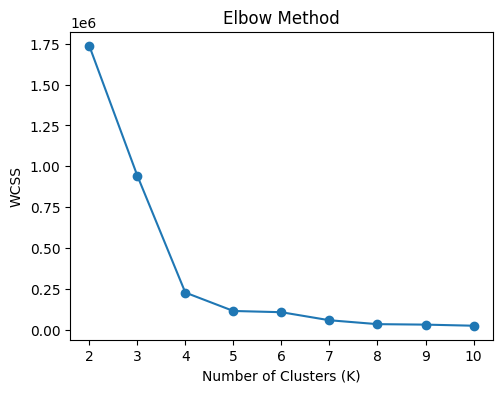

In [36]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(2, 11), wcss, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS")
plt.title("Elbow Method")

In [37]:
# plt.subplot(1, 2, 2)
# plt.plot(range(2, 8), silhouette_scores, marker='o', color='green')
# plt.xlabel("Number of Clusters (K)")
# plt.ylabel("Silhouette Score")
# plt.title("Silhouette Analysis")
# plt.tight_layout()
# plt.show()

In [38]:
# Fit K-means with optimal K
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(rfm_scaled)
df['cluster'] = clusters

# Inverse-transform cluster centers to original scale
centers_original = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(centers_original, columns=rfm_df.columns)
centers_df.index = [f"Cluster {i}" for i in range(4)]

print("Cluster Centers (Original Scale):\n", centers_df)

Cluster Centers (Original Scale):
            recency_days    frequency  monetary_value
Cluster 0      4.086133  4537.044521    1.740745e+06
Cluster 1     58.981338   236.342108    1.610761e+05
Cluster 2   9268.000000     1.096761    2.569778e+04
Cluster 3     12.000000    24.000000    1.198999e+09


In [39]:
print("--- RFM Cluster Analysis (k=3) ---")

# Get cluster sizes
cluster_sizes = df['cluster'].value_counts().sort_index()

# Define descriptive terms
def describe_recency(value):
    q75 = centers_df['recency_days'].quantile(0.75)
    q25 = centers_df['recency_days'].quantile(0.25)
    if value > q75: return "Inactive"
    if value < q25: return "Very Active"
    return "Moderately Active"

def describe_frequency(value):
    q75 = centers_df['frequency'].quantile(0.75)
    q25 = centers_df['frequency'].quantile(0.25)
    if value > q75: return "Frequent Buyer"
    if value < q25: return "Occasional Buyer"
    return "Regular Buyer"

def describe_monetary(value):
    q75 = centers_df['monetary_value'].quantile(0.75)
    q25 = centers_df['monetary_value'].quantile(0.25)
    if value > q75: return "High-Value"
    if value < q25: return "Low-Value"
    return "Medium-Value"

# Generate summaries
for cluster in centers_df.index:
    cluster_id = int(cluster.split()[-1])
    size = cluster_sizes.get(cluster_id, 0)
    
    print(f"\n--- {cluster} (Size: {size}) ---")
    print(f"Recency:   {centers_df.loc[cluster, 'recency_days']:.1f} days ({describe_recency(centers_df.loc[cluster, 'recency_days'])})")
    print(f"Frequency: {centers_df.loc[cluster, 'frequency']:.1f} transactions ({describe_frequency(centers_df.loc[cluster, 'frequency'])})")
    print(f"Monetary:  ${centers_df.loc[cluster, 'monetary_value']:.2f} ({describe_monetary(centers_df.loc[cluster, 'monetary_value'])})")
    print("Action: ", end="")
    if "Inactive" in describe_recency(centers_df.loc[cluster, 'recency_days']):
        print("Re-engage with personalized offers.")
    elif "High-Value" in describe_monetary(centers_df.loc[cluster, 'monetary_value']):
        print("Retain with VIP perks or loyalty programs.")
    else:
        print("Upsell/cross-sell opportunities.")

--- RFM Cluster Analysis (k=3) ---

--- Cluster 0 (Size: 280809) ---
Recency:   4.1 days (Very Active)
Frequency: 4537.0 transactions (Frequent Buyer)
Monetary:  $1740744.83 (Medium-Value)
Action: Upsell/cross-sell opportunities.

--- Cluster 1 (Size: 445622) ---
Recency:   59.0 days (Moderately Active)
Frequency: 236.3 transactions (Regular Buyer)
Monetary:  $161076.12 (Medium-Value)
Action: Upsell/cross-sell opportunities.

--- Cluster 2 (Size: 162049) ---
Recency:   9268.0 days (Inactive)
Frequency: 1.1 transactions (Occasional Buyer)
Monetary:  $25697.78 (Low-Value)
Action: Re-engage with personalized offers.

--- Cluster 3 (Size: 16) ---
Recency:   12.0 days (Moderately Active)
Frequency: 24.0 transactions (Regular Buyer)
Monetary:  $1198998816.38 (High-Value)
Action: Retain with VIP perks or loyalty programs.


In [40]:
from sklearn.mixture import GaussianMixture
import numpy as np

# Fit GMM (using 3 components for consistency)
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_clusters = gmm.fit_predict(rfm_scaled)
df['gmm_cluster'] = gmm_clusters

# Calculate cluster means (original scale)
gmm_means_original = scaler.inverse_transform(gmm.means_)
gmm_centers_df = pd.DataFrame(gmm_means_original, columns=rfm_df.columns)
gmm_centers_df.index = [f"Cluster {i}" for i in range(3)]

print("GMM Cluster Centers (Original Scale):\n", gmm_centers_df)


GMM Cluster Centers (Original Scale):
            recency_days    frequency  monetary_value
Cluster 0      4.783213  4242.988924    1.807662e+06
Cluster 1     61.491501   210.297263    7.059999e+04
Cluster 2   9268.000000     1.096754    2.658658e+04


In [41]:
def describe_cluster(row):
    recency = row['recency_days']
    frequency = row['frequency']
    monetary = row['monetary_value']
    
    # Assign labels
    recency_label = "Inactive" if recency > 30 else "Active"
    frequency_label = "Frequent" if frequency > 50 else "Occasional"
    monetary_label = "High-Value" if monetary > 5000 else "Low-Value"
    
    return pd.Series({
        'Recency': recency_label,
        'Frequency': frequency_label,
        'Monetary': monetary_label
    })

# Generate labels for clusters
cluster_labels = gmm_centers_df.apply(describe_cluster, axis=1)

# Print summaries
for cluster in gmm_centers_df.index:
    size = (df['gmm_cluster'] == int(cluster.split()[-1])).sum()
    labels = cluster_labels.loc[cluster]
    
    print(f"\n--- {cluster} (Size: {size}) ---")
    print(f"Recency:   {labels['Recency']}")
    print(f"Frequency: {labels['Frequency']}")
    print(f"Monetary:  {labels['Monetary']}")
    print("Recommended Actions:")
    if labels['Recency'] == "Inactive":
        print("- Reactivate via win-back campaigns.")
    elif labels['Monetary'] == "High-Value":
        print("- Offer exclusive rewards or tiered loyalty programs.")
    else:
        print("- Cross-sell complementary products.")


--- Cluster 0 (Size: 304546) ---
Recency:   Active
Frequency: Frequent
Monetary:  High-Value
Recommended Actions:
- Offer exclusive rewards or tiered loyalty programs.

--- Cluster 1 (Size: 421900) ---
Recency:   Inactive
Frequency: Frequent
Monetary:  High-Value
Recommended Actions:
- Reactivate via win-back campaigns.

--- Cluster 2 (Size: 162050) ---
Recency:   Inactive
Frequency: Occasional
Monetary:  High-Value
Recommended Actions:
- Reactivate via win-back campaigns.


In [49]:
sample_size = 20000  # Use a subset if your dataset is large
sampled_indices = np.random.choice(rfm_scaled.shape[0], sample_size, replace=False)
rfm_sampled = rfm_scaled[sampled_indices]
clusters_sampled = df['cluster'].iloc[sampled_indices]  # Use your cluster labels

# 2. Run t-SNE with optimized parameters
tsne = TSNE(
    n_components=2,
    perplexity=30,       # Lower for smaller datasets (default=30)
    n_iter=500,          # Reduce iterations for speed (default=1000)
    random_state=42
)
rfm_tsne = tsne.fit_transform(rfm_sampled)


/Users/diasnurullaev/Desktop/freedom/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


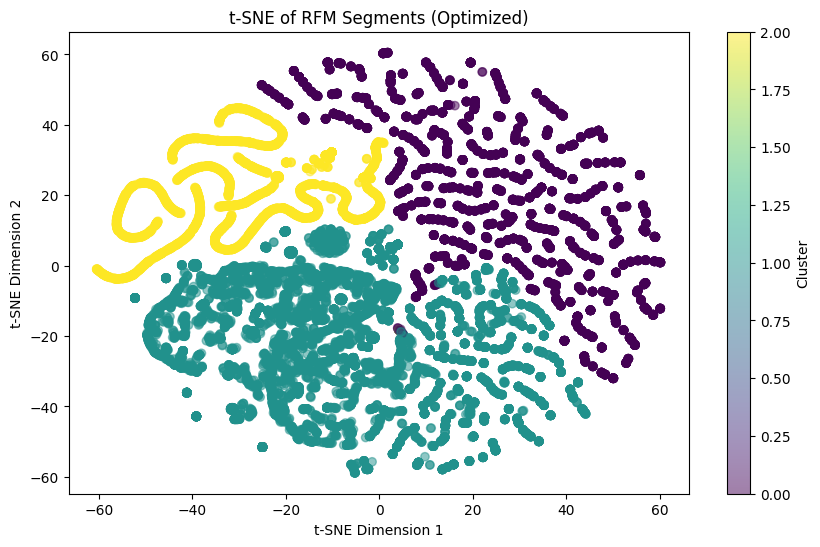

In [50]:
plt.figure(figsize=(10, 6))
plt.scatter(rfm_tsne[:, 0], rfm_tsne[:, 1], c=clusters_sampled, cmap='viridis', alpha=0.5)
plt.title("t-SNE of RFM Segments (Optimized)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.colorbar(label='Cluster')
plt.show()